<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WLK_%2B_MMH_Debiasing_Classification_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness in Occupational Fatigue Detection
    

# Content

---


- **Dataset**
    - MMH & WLK datasets (merged)
    - **Sensitive attribute**: age (in buckets of 10 years) & task
    - The dataset has an unqeual sample size for both age and task groups. 
- **Domain**
    - Operations management - fatigue detection 
- **ML task**
    - SVM (rbf)
    - RFC 
    - Linear regression
- **Fairness tasks**
    - Assessment of unfairness 
    - Mitigation of unfairness with a focus on equal **FALSE NEGATIVE RATE** and **SELECTION RATE**


- **Model performance metrics**:
    - Confusion matrix
    - Recall, accuracy & precision
    - ROC curve

- **Model fairness metrics**:
    - Equalized odds
    - False negatives and False negative rate

- **Mitigation algorithms**:
*the objective is to reduce false negatives / make them equal (avoid burn out of employees)*
    - Reweighting (aif360)
    - Exponential gradient (
    - ThresholdOptimizer

> NOTE: all models are trained unawarene of the sensitive attribue -- sensitive attributes are not inlcuded in training data: 

```
    C=c(x, A) = c(X)
```



> HOWEVER: in Operations management, and especially in the measure of fatigue, physiological data is used for each participant, this can act as a proxy to the sensitive attribute. 


For ths final representation of the model a **MODEL CARD** will be presented. 



    


# Introduction

---


In this notebook, we use algorithmic models to detect fatigue in an occupational setting. 

The objective of the algorithm is to detect (through a classification algorithm) the state of the employee to better accomodate their working conditions and allow for more productive work. 


The notebook emulates the problem presented in Maman et. al.'s (2020) work. In this notebook, we take the analysis a step further, looking at how fair the proposed algorithm is on an group level. 

We train a fairness-unaware algortihm on the presented dataset, with the aim to porve that there is a underlying bias in the methodology, and then proceed in applying de-biasing tecchniques.

## What is fairness?
---

Fairness is complex & contextual, there is no one-size fits all appraoch. Additioanlly, we often have to make cost/benefit decisions, as models that have higher overall perfromance metrics are not necessarily fair towards minority groups. 

In Operations Management, the question arises:


> *Can we create generalised models (vs. personalised ones) without these disciminitaing towards minority groups?* 

This is an important question as personalized models are significantly more expensive to set up.


Furthermore, when creating general codes for people, it is important to consider: 

1. who will the product empower/service and who will be left out? The objectives have to be clear

2. who is writing the code & is the team aware of diverse and inclusive practices

3. whose data is inlcuded in the process, and how this is collected. Topics to consider include: - historical patterns, consent, privarcy, exclusion of specific gorups, etc. 

4. who can monitor the outcome and how? Is the model transparent & has it been well documented?

5. does the outcome have a disciminatory impact? and, if so, how can the negative impact be rectified?


We also have to consider the taxonomy of possible bias sources:
1. Selection bias, reporting bias, sampling bias
2. Interpretation bias - correlation falacy (correlation =! causation); overgeneralization, automation bias


These questions will be covered by the moel card and the written report to this code. 

---

##  The Dataset:  MMA + WLK data
---



The MMA& WLK datasets has been provided by -----, with the main use to detect and predict fatigue in employees doing manual material handling activities. 

The first present a simulated manual material handling (MMH) task, and the second is a supply pick-up and insertion (SI) task.

Twenty four participants (9 females, 15 males; mean age 36.37 years with the standard deviation of 16.67 years) partook in the test. All participants reported that they were in good physical and mental health. Participants completed one three-hour experimental session for the simulated MMH task and another for the SI task. The order
of the two experiments was randomized and participants had to complete the experiments in different days. As a result, we ended up with 15 participants whose data were deemed reliable for analysis. 

Note that the data has been cleaned, and the needed parameters for the model have been calculated by the owner of the dataset (sensor selection, data preprocessing and feature generation (HRR, jerk, etc)), and unchaged features have been removed.

Fatigue is measured through HR and INN data. 

The age of participants will be rounded to the closest 10 years, in order to group participants into groups.

The columns contain mostly boolean and categorical data (including age and various test results).


# Base code
------

### Libraries

In [ ]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from IPython import display
from datetime import date

In [ ]:
# !pip install model-card-toolkit
!pip install --upgrade fairlearn==0.7.0
!pip install fairml
!pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fairml: filename=fairml-0.1.1.5rc1-py3-none-any.whl size=8804 sha256=0a94591912954ccd5b27a273c589f02b03dbbbf241c979f27fc8a8c9968a2b4c
  Stored in directory: /root/.cache/pip/wheels/6f/44/b7/07613082ee66d893ca0e252d2a5793cd371fcf5107c477234d
Successfully built fairml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.5 MB/s 
     |████████████████████████████████| 564 kB 38.6 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=3bf57e013a8bd8051f04e4bfdc473100cdd942fb838223265f3019fe01018f8b
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5

### Data load and wrangling

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# open csv MMH dataset
df_MMH = pd.read_csv('/content/drive/MyDrive/00 - thesis/Code/Datasets/Fatigue-modeling-master/MMH_15p.csv', sep=',')
df_WLK = pd.read_csv('/content/drive/MyDrive/00 - thesis/Code/Datasets/Fatigue-modeling-master/WLK_13p.csv', sep=',')

In [ ]:
# make column names the same for both dfs
df_MMH['fatiguestate'] = df_MMH['fatiguestate1']
df_WLK['fatiguestate'] = df_WLK['Fatigue state']
df_WLK['subject'] = df_WLK['subject'].apply(lambda x: x+'00')

df_MMH.rename(columns = {'age':'Age', 'HRR-Mean': 'HRR.Mean', 'HRR-CV':'HRR.CV'}, inplace = True)
df_MMH.columns = df_MMH.columns.str.replace('coefficient.of.variation', 'CV')

df_MMH = df_MMH.drop(['fatiguestate1'], 1)
df_WLK = df_WLK.drop(['Fatigue state'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# merge datasets
df = pd.concat([df_MMH, df_WLK])

In [ ]:
df = df.dropna(axis='columns')

In [ ]:
# delete:
## fatiguestate (already in fatiguestate1); Unnamed (no critical information); gender (only available in one dataset)
df = df.drop(['Unnamed: 0'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.task.unique()

array(['MMH', 'WLK'], dtype=object)

In [ ]:
# convert subject & task to numerical values 
df['subject'] = df['subject'].str.replace('P','')
df['task'] = df['task'].str.replace('MMH', '1')
df['task'] = df['task'].str.replace('WLK', '2')

task
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

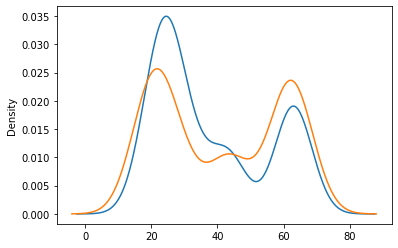

In [ ]:
# check gender & age representation 
df.groupby('task').Age.plot(kind='kde')

In [ ]:
# bin age into groups to noramlize
def custom_round(x, base):
    return base * round(float(x)/10)

df['Age'] = df.Age.apply(lambda x: custom_round(x, 10))

In [ ]:
# for this dataset features are NOT normalised, as preprocessing of data has already peen carried out by the owners of the dataset. How this is done is described in detail in their code & paper cited above. 
# in case of wanting to normalise, I would suggest normalising only mean values - variation has already been pre-calculated, and so is the HHR values (% of total possible HR)
# you can use (pandas or sklearn library 'preprocessing.MinMaxScaler'): 
# normalized_df=(df-df.min())/(df.max()-df.min())
# normalized_df=(df-df.mean())/df.std()


'''https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'''

'https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'

### Exploratory analysis 

In [ ]:
# there is 18 entries per subject

# for i in categorical_values:
#  print (f'counts for {i}: {chr(10)} {df[i].value_counts()/18} {chr(10)} frequency for {i}: {chr(10)} {df[i].value_counts(normalize=True)}')

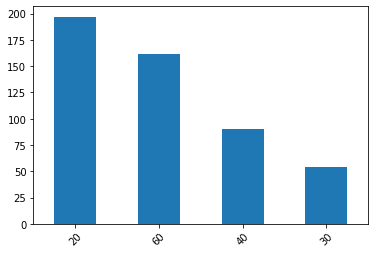

In [ ]:
df["Age"].value_counts().plot(kind='bar', rot=45)

In [ ]:
# drop subject as it is not relevant for analysis
df_1 = df.drop(['subject'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


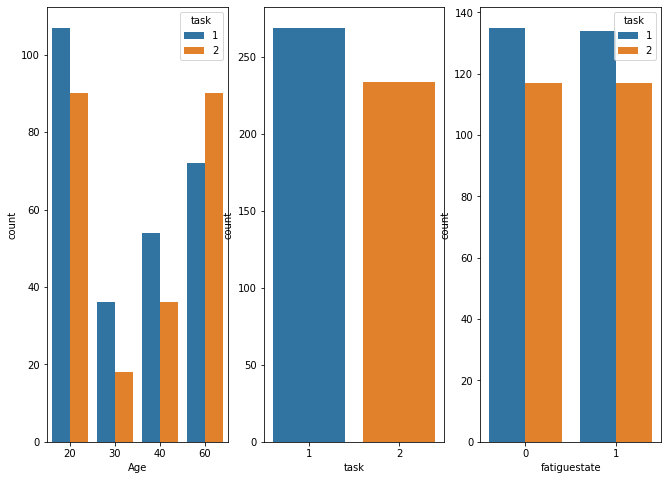

In [ ]:
# check sample distributions
fig, ax = plt.subplots(1,3)
fig.set_size_inches(11, 8)
sns.countplot(df_1['Age'], ax=ax[0], hue=df_1.task)
sns.countplot(df_1['task'], ax=ax[1])
sns.countplot(df_1['fatiguestate'], ax=ax[2], hue=df_1.task)
fig.show()

Task and fatigue state is well distributes in sample; age is not (1 participant has about 18 entries, there are only 2 participants in their 30s)

Pairplots analysis not appropiate with the high number of attributes therefore deleted.


In [ ]:
df.columns
cols = ['subject', 'task', 'Age', 'fatiguestate',  
        'HRR.Mean', 'HRR.CV',
        'Wrist.jerk.Mean', 
        'Ankle.jerk.Mean', 'Ankle.ACC.Mean', 'Ankle.xposture.Mean',
        'number of steps', 'average step time', 'average step distance',
        'time bent', 
        'mean hip osicllation', 'mean foot osicllation', 
        'leg rotational velocity sag plane', 'leg rotational position sag plane', 
        'Wrist.jerk.CV', 'Wrist.ACC.CV',
        'Hip.jerk.CV', 'Hip.ACC.CV', 'Hip.yposture.CV']

cols_rfc = ['subject', 'task', 'Age', 'fatiguestate', 
            'HRR.Mean', 'HRR.CV', 
            'Wrist.jerk.Mean', 'Ankle.xposture.Mean',
            'average step time', 
            'leg rotational velocity sag plane',
            'leg rotational position sag plane',
            'Wrist.jerk.CV', 'Wrist.ACC.CV', 
            'Hip.ACC.CV']

# for cross validation, we get better refults if we don't implement the rfc attributes only 

df = df[cols]

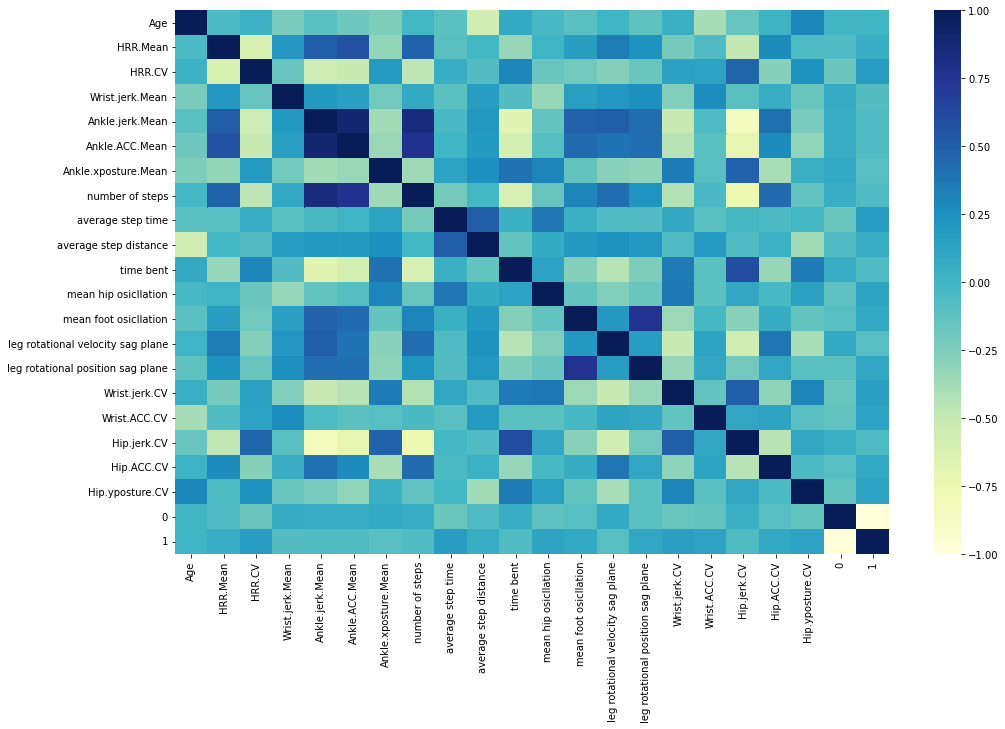

In [ ]:
# correlation analysis 
df_corr = pd.concat([df.drop('fatiguestate', axis=1), pd.get_dummies(df['fatiguestate'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr,  cmap="YlGnBu")

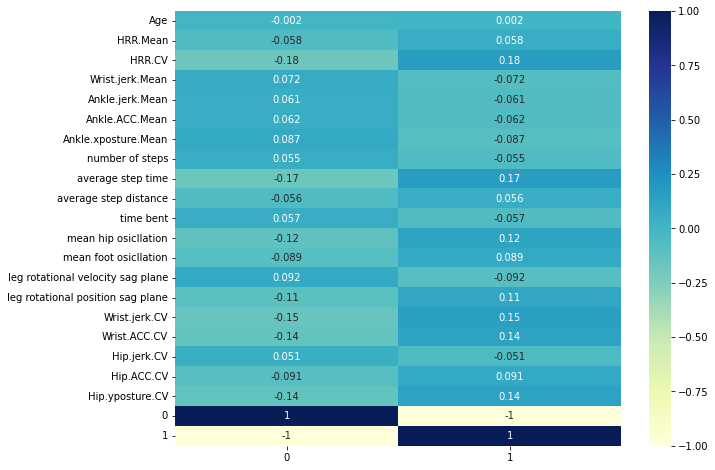

In [ ]:
# all features with a corr. under |0.05| are removed
feats = df.columns[1:]

df_corr = pd.concat([df[feats].drop('fatiguestate', axis=1), pd.get_dummies(df[feats]['fatiguestate'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0,1]], annot=True, cmap="YlGnBu")

## Stress Model

---


Using the work by Maman et al. (2020) as a base, we apply a fairness unaware model, namely **SVM (circular kernel), RF and a a generic lgm model (logistic regression).** 


> Note - decision trees are non-parametric supervised learning models for classigfication 


Lasso/ best subset selection methods were applied for feature selection, following the combinations with the highest accuracy in the report by Maman et al. (2020).
Cross validation scores were taken to ensure the performance of the generic model for all participants.   

**Evaluations:**

With the goal of obtianing a fair model in mind, the models are evaluated on:
- their overall scores (confusion matrix, recall & precision)
- their performance by groups, false negatives rates & false negative rate (age & task)

<br> 


---


<br> 
 


Sources: https://www.sciencedirect.com/science/article/pii/S0957417420302293 & https://zahrame.github.io/FatigueManagement.github.io/ (code in R) 


### Model set-up: libraries & helper functions

In [ ]:
# libraries for model selection 
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedShuffleSplit

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# libraries for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

# libraries for metrics of models
import sklearn.metrics as skm
from sklearn.metrics import (
    accuracy_score,
    roc_curve, 
    auc,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,  
    PrecisionRecallDisplay,
    balanced_accuracy_score,
    roc_auc_score,
    recall_score,
    confusion_matrix, ConfusionMatrixDisplay,
    plot_roc_curve)

from sklearn import set_config

set_config(display="diagram")

### Model set-up: test/train split 

In [ ]:
# set test & train data & defining age as sensitive attribute
X = df.drop(columns=['task', 'Age', 'fatiguestate'])
y = df['fatiguestate']

A = df[['Age', 'task']]
task_str = A['task'].map({ 1:"MMK", 2:"WLK"})

In [ ]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, task_str_train, task_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.4, # increse number for more fairness 
    random_state=42)


### Model set-up: defining classifiers

In [ ]:
from numpy import random 
# set up model:
classifiers = [RandomForestClassifier(n_estimators = 100, random_state = random.seed(123)),
               LogisticRegression(random_state = 42),
               SVC(kernel='rbf', C = 1000, gamma = 0.01, probability = True)]

#### RF feature selection - best subset

In [ ]:
# feature selection Random Forest
## 1. Best subset selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

sel.get_support()

selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat)) # --> provides 10 - in line with previous paper
print(selected_feat)


8
Index(['HRR.Mean', 'HRR.CV', 'Wrist.jerk.Mean', 'average step time',
       'leg rotational velocity sag plane', 'Wrist.jerk.CV', 'Wrist.ACC.CV',
       'Hip.ACC.CV'],
      dtype='object')


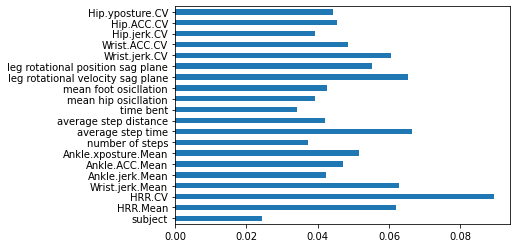

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

features = list(X)

pd.Series(rfc.feature_importances_, index=features).plot(kind='barh')

#### log reg feature selection - LASSO

In [ ]:
# feature selection using LASSO - based on https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a#:~:text=How%20can%20we%20use%20it,its%20coefficient%20equal%20to%200.
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('model',Lasso())
                     ])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

# search.fit(X_train,y_train)
# search.best_params_
# coefficients = search.best_estimator_.named_steps['model'].coef_

# 'model__alpha': 0.2

In [ ]:
# importance = np.abs(coefficients)
# np.array(features)[importance > 0]

#### SVM param. selection

In [ ]:
'''C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" 
      % (grid.best_params_, grid.best_score_))
'''

# The best parameters are {'C': 1000.0, 'gamma': 1e-05} with a score of 0.86

'C_range = np.logspace(-2, 10, 13)\ngamma_range = np.logspace(-9, 3, 13)\nparam_grid = dict(gamma=gamma_range, C=C_range)\ncv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)\ngrid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)\ngrid.fit(X, y)\n\nprint("The best parameters are %s with a score of %0.2f" \n      % (grid.best_params_, grid.best_score_))\n'

## Model evaluation
-----

### Model evaluation - confusion matrix test & train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_

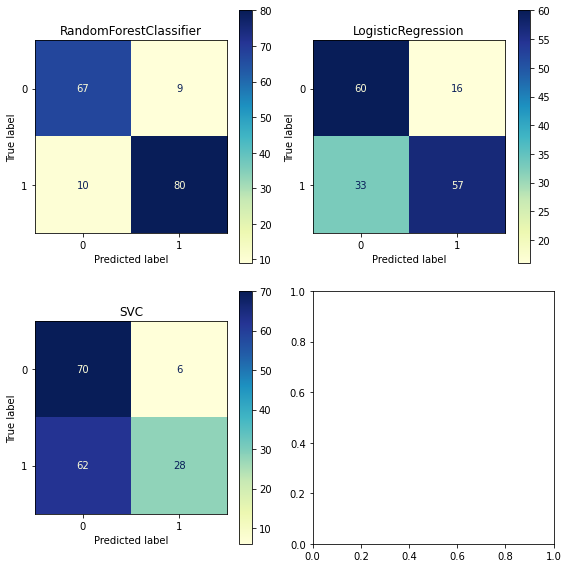

In [ ]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_

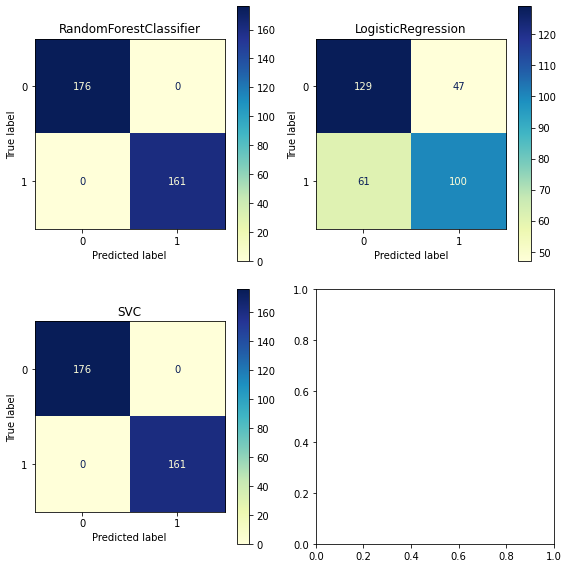

In [ ]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

### Model evaluation - cross validation scores

In [ ]:
# train model, get accuracies and CV
groups = X_test['subject']
gkf = GroupKFold(n_splits=4)

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores = cross_val_score(model, X_test, y_test, cv=gkf, groups=groups, scoring='accuracy')
  print (f'{model}  {chr(10)} CV: {scores.mean()} {chr(10)}')

RandomForestClassifier()  
 CV: 0.6637630662020906 

LogisticRegression(random_state=42)  
 CV: 0.6686991869918699 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


SVC(C=1000, gamma=0.01, probability=True)  
 CV: 0.5360046457607434 



### Model evaluation - classification report (precision, recall, f1, support, accuracy)

In [ ]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}')

RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       0.88      0.87      0.87        76
           1       0.89      0.90      0.90        90

    accuracy                           0.89       166
   macro avg       0.89      0.88      0.88       166
weighted avg       0.89      0.89      0.89       166

LogisticRegression(random_state=42): 
               precision    recall  f1-score   support

           0       0.65      0.79      0.71        76
           1       0.78      0.63      0.70        90

    accuracy                           0.70       166
   macro avg       0.71      0.71      0.70       166
weighted avg       0.72      0.70      0.70       166

SVC(C=1000, gamma=0.01, probability=True): 
               precision    recall  f1-score   support

           0       0.53      0.92      0.67        76
           1       0.82      0.31      0.45        90

    accuracy                           0.59       166
   macro avg    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Model evaluation - precision/ recall

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


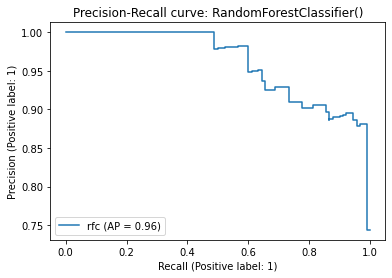

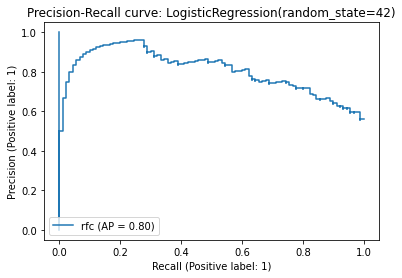

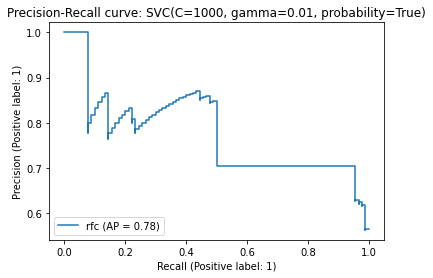

In [ ]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')

### Model evaluation - ROC

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


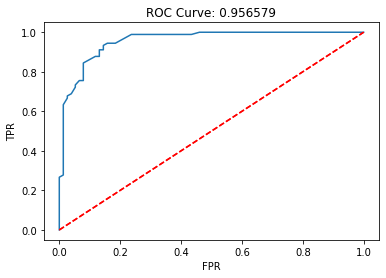

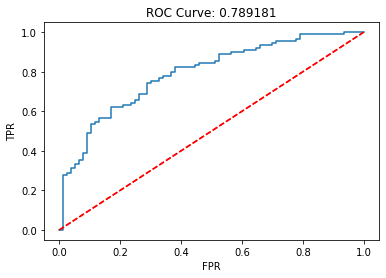

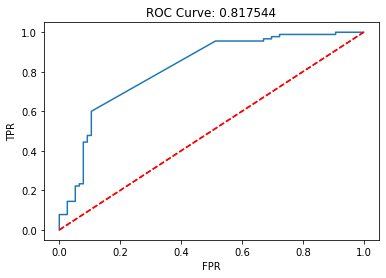

In [ ]:
# scores on test set
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred)
  ax = (
      pd.DataFrame(tpr, index=fpr)
      .plot(legend=False, title=('ROC Curve: %f' % auc(fpr, tpr)))
  )
  ax.plot([(0,0), (1,1)], 'r--')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')

## Fairness Measure

---



Check for confusion matrix


> Note: Accuracy, recall & precision are not called for when usign Decision Tree models.


**Equalised odds** (we want to ensure that the number of false negatives is equally low; we need to reduce false positives which can be costly (variable is not subjective anyways)) -- balance for negative class

also check AUC unmitigated & dispartities between exact groups.


We aim for group fairness - participants with similar characteristics should be treated similarily




CONSIDER:
1. disaggregated evaluations - evaluating perfromance with respect to different subgroups (age/ task)



---
<br>

For supervised classification --> output should be the same accross sensitive characterisitcs - bias if the decision changes after beig exposed to additioanl sensitve feature inputs 
<br>

Sources: 
- https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=openscale-fairness-metrics-overview


- https://github.com/fairlearn/fairlearn



- https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text=Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D

- https://github.com/valeria-io/bias-in-credit-models/blob/master/model_analysis/model_fairness_interventions.ipynb

### Install libraries & helper functions

In [ ]:
# libraries for fairness metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [ ]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate},
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group
  
def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})
  


### Fairness evaluation - confusion matrix by group


In [ ]:
# define sensitive attributes
task = A_test['task']
age =  A_test['Age']


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')
  print(f'Task:{chr(10)}{model}: {chr(10)} {metric_frame (task)} {chr(10)}')



/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

Age:
RandomForestClassifier(): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.233333  0.032258  0.967742  0.766667
30        0.3       0.0       1.0       0.7
40        0.0  0.066667  0.933333       1.0
60   0.043478     0.125     0.875  0.956522 

Task:
RandomForestClassifier(): 
            FPR       FNR       TPR       TNR
task                                        
1     0.209302  0.042553  0.957447  0.790698
2     0.060606  0.093023  0.906977  0.939394 

Age:
LogisticRegression(random_state=42): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.166667  0.483871  0.516129  0.833333
30        0.5  0.083333  0.916667       0.5
40   0.461538       0.2       0.8  0.538462
60   0.130435     0.375     0.625  0.869565 

Task:
LogisticRegression(random_state=42): 
            FPR       FNR       TPR       TNR
task                                        
1     0.255814  0.404255  0.595745  0.74

### Fairness evaluation - fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [ ]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')


Age:
RandomForestClassifier(): 
                                Unmitigated
Equalized_odds_difference              0.3
Demographic parity difference     0.190909
Demographic parity ratio              0.72
------                                    
Overall balanced error rate       0.111257
Balanced error rate difference        0.15
 ------                                   
False positive rate difference         0.3
False negative rate difference      0.1875
Equalized odds difference              0.3
  ------                                  
Overall AUC                       0.958699
AUC difference                    0.044086 

Age:
LogisticRegression(random_state=42): 
                                Unmitigated
Equalized_odds_difference         0.400538
Demographic parity difference      0.38301
Demographic parity ratio          0.473361
------                                    
Overall balanced error rate       0.297222
Balanced error rate difference    0.078052
 ------           

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Age:
SVC(C=1000, gamma=0.01, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.669231
Demographic parity difference     0.311688
Demographic parity ratio          0.673469
------                                    
Overall balanced error rate       0.311696
Balanced error rate difference    0.334615
 ------                                   
False positive rate difference    0.669231
False negative rate difference     0.09375
Equalized odds difference         0.669231
  ------                                  
Overall AUC                       0.874708
AUC difference                    0.156863 



In [ ]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Task:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, task)} {chr(10)}')

### Fairness evaluation - AUC by group

In [ ]:
# AUC curve 

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  metric_frame_unmitigated_age = MetricFrame(roc_auc_score, y_test, y_pred, sensitive_features=age)

  auc_unmitigated_age = summary_as_df("auc_unmitigated", metric_frame_unmitigated_age)
  auc_unmitigated_age

  metric_frame_unmitigated_task = MetricFrame(roc_auc_score, y_test, y_pred, sensitive_features=task)

  auc_unmitigated_task = summary_as_df("auc_unmitigated", metric_frame_unmitigated_task)
  auc_unmitigated_task

  print(f'Age:{chr(10)}{model}: {chr(10)} {auc_unmitigated_age} {chr(10)}')
  print(f'Task:{chr(10)}{model}: {chr(10)} {auc_unmitigated_task} {chr(10)}')

##### helper function for visualisation


In [ ]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2 ### change to 4/2 depending on the sensitive attribute (Age vs. task)
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### Visualisation - performance metric by groups (age)


---

check code from paper on visual identification


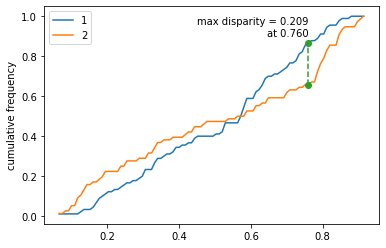

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


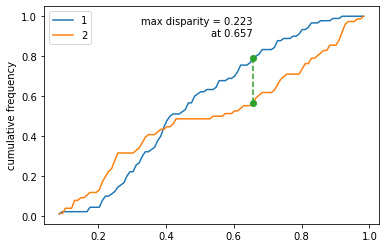

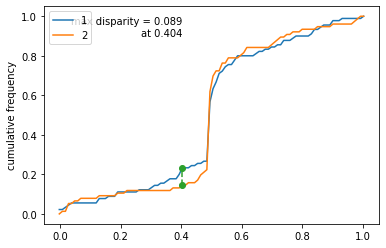

In [ ]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, task)
  display(HTML('</span>'))

In [ ]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, age)
  display(HTML('</span>'))

AssertionError: ignored

# Debiasing the model

---


In this part we aim to mitigate bias (removing the problematic signal) through the addition of inclusion (add singal for deasired features for a re-weighted singal to improved fairness)

The dataset is not balanced for any of the groups present (different sample numbers) 


> NOTE: Bias can come from the acutal data or the algorithm (this includes technical bias from data processing & amplified bias from the feedback loops)


#### Reminder to types of fairness and how to approach them

- Demographic parity applies different classifciaiton thresholds per group while keeping the same fraction of +ives
- Equal opp. uses different classifciaiton thresholds per group while keeping the same true positive rate
- Equalized odds uses different classifciaiton thresholds per group while keeping the same true positive&false rate


**We aim for equalized odds (EO) and ERP (error rate parity) cross groups.**



#### De-biasing methods overview:

 - pre-processing: reweighing, disparate impact remover
 (data transportation, database reparis, data augmentation)

 - in-process: adversarial debiasing, prejudice remover

- post process-process: through reductions: Exponential gradient (for disparity mitigation), Gridsearch,  ThresholdOptimizer, equalized odds/ calibrated offd/ reject option classification


> NOTE: fairlearn only supports binary classificaiton 



STEPS:
1. Pre-processing --> reweigh sample 
                  --> balance perfromance metric (already the case equal number of stressed/ non stressed people

2. in process --> adversarial debiasing

3. post process --> exponentiatedgradient, threshold optimizer, equalizedodds




> Note: the base model already use **bias mitigation through unawareness** (this is standard practice), the sensitive attriabute IS NOT included in the training data -->  C=c(x, A) = c(X)




https://proceedings.neurips.cc/paper/2020/file/03593ce517feac573fdaafa6dcedef61-Paper.pdf

https://proceedings.neurips.cc/paper/2021/file/43c656628a4a479e108ed86f7a28a010-Paper.pdf


https://arxiv.org/pdf/1810.01943.pdf



#### import libraries and helper functions

In [ ]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  TruePositiveRateParity,
                                  GridSearch)

from fairlearn.metrics import (MetricFrame,
                               true_positive_rate,
                               false_positive_rate,
                               false_negative_rate,
                               selection_rate,
                               count,
                               false_negative_rate_difference)



from IPython.display import Markdown, display
import matplotlib.pyplot as plt

#### 1. Reweigh samples for age (AIF360)

http://arno.uvt.nl/show.cgi?fid=157880

https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb


In [ ]:
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="fatiguestate",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['Age', 'task'], 
                                         privileged_classes= [lambda x: x >= 31],
                                         features_to_drop=['subject'])

In [ ]:
# test, train split

ds_train, ds_test = ds_aif.split([0.7], shuffle=True)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.030549


In [ ]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'Age': 0}]
priv = [{'Age': 1}]

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                               privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [ ]:
# check for metric before and after transforming 
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(f'Before reweighing {explainer_train.disparate_impact()}')
print(f'After reweighing {explainer_transf_train.disparate_impact()}')

Before reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.967032967032967
After reweighing Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000004


In [ ]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

###### evaluations

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

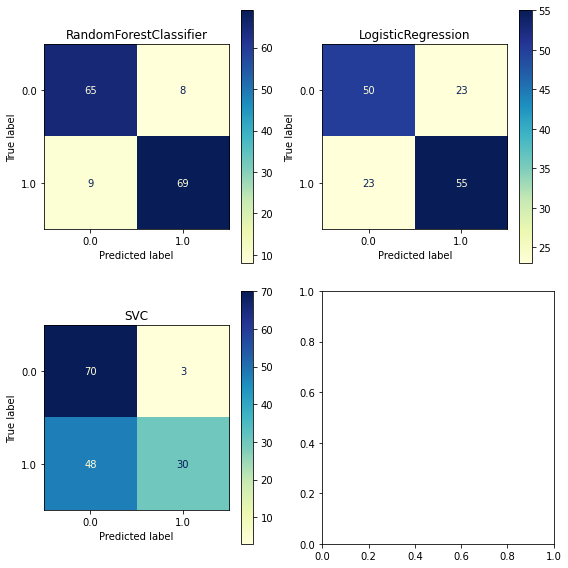

In [ ]:
# train models with reweighted data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the cl

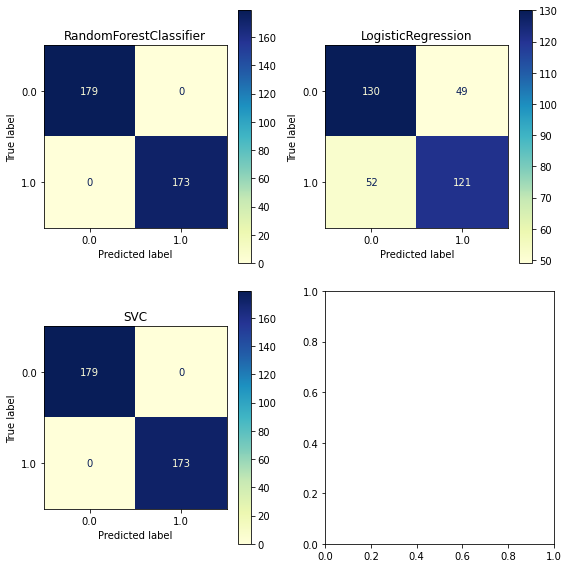

In [ ]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [ ]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

NameError: ignored

###### fairness evaluations

In [ ]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [ ]:
for model in classifiers:

  model.fit(RW_train.features, RW_train.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = model.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = model.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = model.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')
  
  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')

ValueError: ignored

#### 2. Adverserial debiasing (AIF360)


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(ds_train, 
                                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(ds_test, 
                                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.030549
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.059775


In [ ]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

sess = tf.Session()
sess.close()

tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = priv,
                                                   unprivileged_groups = unpriv,
                                                   scope_name = 'plain_classifier',
                                                   debias = True,
                                                   sess=sess)

debiased_model.fit(ds_train)

In [ ]:
# Apply the plain model to test data
ds_debiasing_train = debiased_model.predict(ds_train)
ds_debiasing_test = debiased_model.predict(ds_test)

In [ ]:
# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(ds_debiasing_train, 
                                                          privileged_groups = priv,
                                                          unprivileged_groups = unpriv,)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(ds_debiasing_test, 
                                                         privileged_groups = priv,
                                                         unprivileged_groups = unpriv,)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.033197
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.034986


https://nbviewer.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb#3.-Training-models-on-original-2015-Panel-19-data

##### model evaluation


#### Fair learn - post processign methods -- wrappers



In [ ]:
# set test & train data & defining age as sensitive attribute
X = df.drop(columns=['Age', 'fatiguestate'])
y = df['fatiguestate']

A = df[['Age']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.4, # increse number for more fairness 
    random_state=42)


In [ ]:
metrics_dict = {"false_negative_rate": false_negative_rate,         
                "selection_rate": selection_rate,
                "balanced_accuracy": balanced_accuracy_score
                ,}

In [ ]:
for cls in classifiers:
  unmitigated_pipeline = Pipeline(steps=[("model", cls)])

  unmitigated_pipeline.fit(X_train, y_train)

  Y_pred = unmitigated_pipeline.predict(X_test)

  mf1 = MetricFrame(metrics=false_negative_rate,
                    y_true=y_test,
                    y_pred=Y_pred,
                    sensitive_features=A_test)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

  print(f"{cls}:\n {mf1.by_group}\n"
        f"difference: {mf1.difference():.3}\n"
        f"ratio: {mf1.ratio():.3}\n"
        f"max across groups: {mf1.group_max():.3}\n"
         f"balanced_accuracy_score: {balanced_accuracy_score(y_test, Y_pred)}\n\n")

#### 3. ExponentiatedGradient - reduction (fair learn)

In [ ]:
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=TruePositiveRateParity(difference_bound=0.07)) # for FNR 1-TPR
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  Y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  metricframe_reductions = MetricFrame(metrics=metrics_dict,
                                       y_true=y_test,
                                       y_pred=Y_pred_reductions,
                                       sensitive_features=A_test)
  metricframe_reductions.by_group

  # Evaluate the difference between the largest and smallest value of each metric
  print(f'{cls}:\n',
        f'{metricframe_reductions.difference()} \n\n')


#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

In [ ]:
for cls in classifiers:
  unmitigated_pipeline = Pipeline(steps=[("model", cls)])

  unmitigated_pipeline.fit(X_train, y_train)

  Y_pred = unmitigated_pipeline.predict(X_test)

  metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                                      y_true=y_test,
                                      y_pred=Y_pred,
                                      sensitive_features=A_test)
  
  postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                       constraints="false_negative_rate_parity",
                                       objective="balanced_accuracy_score",
                                       prefit=True,
                                       predict_method='predict_proba')
  
  postprocess_est.fit(X_train, y_train, sensitive_features=A_train)

  Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)

  metricframe_postprocess = MetricFrame(metrics=metrics_dict,
                                        y_true=y_test,
                                        y_pred=Y_pred_postprocess,
                                        sensitive_features=A_test)
  
  df_results = pd.concat([metricframe_unmitigated.by_group,
                          metricframe_postprocess.by_group],
                          keys=['Unmitigated', 'ThresholdOptimizer'],
                          axis=1)
  
  print (f'{cls} - Age:{chr(10)} {df_results}{chr(10)}')
  

NameError: ignored

# ML fairness - summary and future considerations (for report)


---





Best practices:
  - dataset documentation
  -  model reporting and curation
  - reproducibility and transparency



The Model Card Toolkit (MCT) will be used to ensure the correct documentation, model reporting, and transaparency of the set-up model

https://github.com/tensorflow/model-card-toolkit

https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-instructors.ipynb



https://github.com/fairlearn/talks/blob/main/2022_pycon/pycon-2022-instructors.ipynb

In [ ]:
# ! pip install model-card-toolkit

In [ ]:
try:
    from model_card_toolkit import ModelCardToolkit
    from model_card_toolkit.utils.graphics import figure_to_base64str
    model_card_imported = True
except Exception:
    model_card_imported = False
    def figure_to_base64str(*args):
        return None

In [ ]:
# Initialize the Model Card Toolkit with a path to store generate assets
model_card_output_path = ...
mct = model_card_toolkit.ModelCardToolkit(model_card_output_path)

# Initialize the model_card_toolkit.ModelCard, which can be freely populated
model_card = mct.scaffold_assets()
model_card.model_details.name = 'My Model'

# Write the model card data to a proto file
mct.update_model_card(model_card)

# Return the model card document as an HTML page
html = mct.export_format()

In [ ]:
# for graphics: https://github.com/valeria-io/bias-in-credit-models/blob/master/model_analysis/model_fairness_interventions.ipynb
go for negative rate 

## archive of code snipplets


In [ ]:
# proof scaling doesnt mke a difference

from sklearn.preprocessing import StandardScaler, MaxAbsScaler

min_max_scaler = MaxAbsScaler()
ds_train.features = min_max_scaler.fit_transform(ds_train.features)
ds_test.features = min_max_scaler.transform(ds_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(ds_train, 
                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(ds_test, 
                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

check : https://colab.research.google.com/github/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-student.ipynb#scrollTo=HrCelj5_hR6a


'''https://fairlearn.org/v0.5.0/quickstart.html

https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-instructors.ipynb

https://github.com/fairlearn/fairlearn/tree/main/notebooks'''




https://www.ibm.com/docs/en/cloud-paks/cp-data/3.5.0?topic=functions-watson-machine-learning-overview



